In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- Feature engineering
- Missing value imputation
- Prediction!

In [101]:
t_train = pd.read_csv("data/titanic_train.csv")
t_test = pd.read_csv("data/titanic_test.csv")

full = t_train.append(t_test, ignore_index=True, sort=False)

t_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
t_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Feature Engineering ( Arte )

#### Titulo dos passageiros 

In [103]:
import re

def split_it(name):
    return re.sub('(.*, )|(\\..*)', '', name)

full["Title"] = full.Name.apply(split_it)

In [104]:
pd.pivot_table(full, index=['Sex'], columns=['Title'], aggfunc="count")

Age                                                        \
Title  Capt  Col  Don Dona   Dr Jonkheer Lady Major Master   Miss   
Sex                                                                 
female  NaN  NaN  NaN  1.0  1.0      NaN  1.0   NaN    NaN  210.0   
male    1.0  4.0  1.0  NaN  6.0      1.0  NaN   2.0   53.0    NaN   

           ...      Ticket                                                \
Title      ...      Master   Miss Mlle  Mme     Mr    Mrs   Ms  Rev  Sir   
Sex        ...                                                             
female     ...         NaN  260.0  2.0  1.0    NaN  197.0  2.0  NaN  NaN   
male       ...        61.0    NaN  NaN  NaN  757.0    NaN  NaN  8.0  1.0   

                     
Title  the Countess  
Sex                  
female          1.0  
male            NaN  

[2 rows x 198 columns]

#### Combinar titulos raros

In [107]:
titulos_raros = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Renomeando mlle, ms, e mme
full.loc[full["Title"] == 'Mlle', "Title"] = "Miss"
full.loc[full["Title"] == 'Ms', "Title"]   = "Miss"
full.loc[full["Title"] == 'Mme', "Title"]   = "Mrs"
full.loc[full["Title"].isin(titulos_raros), "Title"]   = "Miss"


### Cabine

In [117]:
full.groupby("Cabin").size()

Cabin
A10        1
A11        1
A14        1
A16        1
A18        1
A19        1
A20        1
A21        1
A23        1
A24        1
A26        1
A29        1
A31        1
A32        1
A34        3
A36        1
A5         1
A6         1
A7         1
A9         1
B10        1
B101       1
B102       1
B11        1
B18        2
B19        1
B20        2
B22        2
B24        1
B26        1
          ..
E34        3
E36        1
E38        1
E39 E41    1
E40        1
E44        2
E45        1
E46        2
E49        1
E50        2
E52        1
E58        1
E60        1
E63        1
E67        2
E68        1
E77        1
E8         2
F          1
F E46      1
F E57      1
F E69      1
F G63      2
F G73      2
F2         4
F33        4
F38        1
F4         4
G6         5
T          1
Length: 186, dtype: int64

In [130]:
print("Tamanho:", full.shape, "missing", len(full.loc[full["Cabin"].isnull(), "Cabin"]))

Tamanho: (1309, 13) missing 1014


In [159]:
# Criar Variável Deck apartir da variável cabine
def f(x):
    return str(x)[0] if str(x) != 'nan' else None

full["Deck"] = full["Cabin"].apply(f)

### Lidando com valores missing

In [174]:
# Passengeiros 62 e 830 faltam valores na variavel Embarkment
full.loc[full["PassengerId"].isin([62,830]), ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,B
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,B


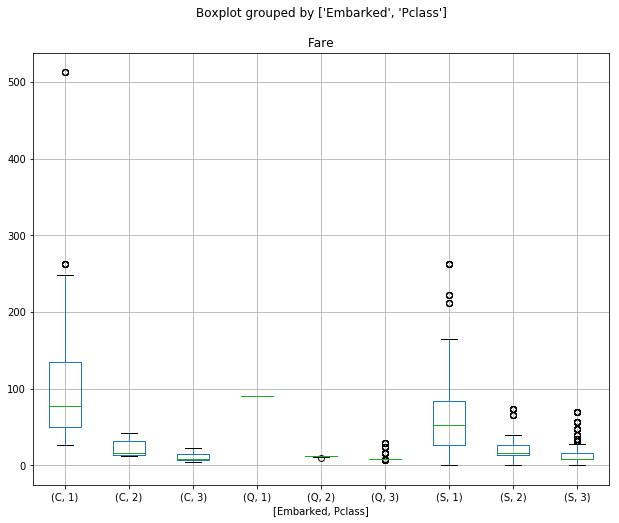

In [216]:
#removendo os passagegeiros 62 e 830

tst = full.loc[~full["PassengerId"].isin([62, 830]), :]
tst.boxplot("Fare", by=["Embarked", "Pclass"], figsize=(10, 8))

O valor médio do ticket para os passageiros de primeira classe que embarcaram em Charbourg ("C")  coincide com os $80 pagos pelos passeigeiros analisados, nesse caso podemos substituir o valor nulo por 'C'

In [218]:
full.loc[full["PassengerId"].isin([62,830]), "Embarked"] = "C"

In [220]:
full.loc[full["PassengerId"] == 1044, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,None


Passageiro de 3º classe que partiu de Southamptom ('S'). Vamos analisar os Fares entres os outros que embarcaram nesse local.

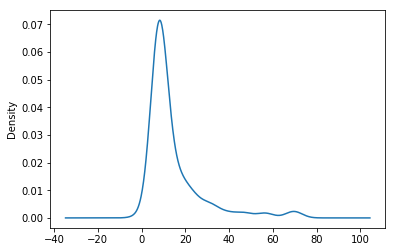

In [249]:
tst = full[(full.Pclass == 3) & (full.Embarked == 'S')]
tst["Fare"].plot.kde(x)

In [260]:
full.loc[full["PassengerId"] == 1044, "Fare"] = tst["Fare"].median()

In [264]:
full[full["Age"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,None
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr,None
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs,None
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr,None
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss,None
29,30,0.0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S,Mr,None
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,Mrs,B
32,33,1.0,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,Miss,None
36,37,1.0,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,Mr,None
42,43,0.0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C,Mr,None


In [304]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,None
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,None
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,None
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,None
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,E
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,None
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs,None
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs,None


### Predict

In [331]:
from sklearn.model_selection import train_test_split
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Deck']

train = full.loc[:, features]
train = pd.get_dummies(train)

In [351]:
print(len(train), len(train.dropna()))

1309 1309


In [354]:
X = train
y = full.loc[:, "Survived"]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [363]:
np.all(np.isfinite(X))


True

In [357]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_leaf_nodes = 10, random_state=0)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)

    

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').